## Note
In this notebook, i just prepare the data then fine tuning VGG16 to diagnosis pneumonia. If you wanna see insight the dataset, please visit this notebook:

-> https://www.kaggle.com/luukhang/build-alexnet-to-classifies-pneumonia.

Comparing the performance of pretrained of VGG16 and ResNet18, plese visit this notebook:

-> https://www.kaggle.com/luukhang/transfer-learning-vgg16-to-classifies-pneumonia

# 1. Import libs

In [67]:
# Common lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Utils
from tqdm import tqdm
import datetime

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, confusion_matrix, auc

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

print("Import successfully")

Import successfully


# 2. Prepare data

In [2]:
# Init variables
input_folder = '../input/coronahack-chest-xraydataset'
test_img_folder = os.path.join(input_folder, 'Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset', 'test')
train_img_folder = os.path.join(input_folder, 'Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset', 'train')
metadata_df = pd.read_csv(os.path.join(input_folder, 'Chest_xray_Corona_Metadata.csv'), index_col=0)

In [3]:
# Split to train & test set
train_df = metadata_df[metadata_df.Dataset_type == 'TRAIN'].reset_index(drop=True)
test_df = metadata_df[metadata_df.Dataset_type == 'TEST'].reset_index(drop=True)

# Check train_df size + test_df size == metadata_df size
assert train_df.size + test_df.size == metadata_df.size

print(f'Shape of train data: { train_df.shape }')
print(f'Shape of test data: { test_df.shape }')

Shape of train data: (5286, 5)
Shape of test data: (624, 5)


In [4]:
# fill na
train_df.fillna('unknow', inplace=True)
test_df.fillna('unknow', inplace=True)

In [5]:
# Image augmentation
train_datagen = ImageDataGenerator(rotation_range=10,
                              brightness_range=(0.8, 1.2),
                              zoom_range=[0.75, 1],
                              horizontal_flip=True)
test_datagen = ImageDataGenerator()

In [6]:
train_df, valid_df = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=42)

In [7]:
train_batches = train_datagen.flow_from_dataframe(train_df,
                                             directory=train_img_folder,
                                             x_col='X_ray_image_name',
                                             y_col='Label',
                                             class_mode='binary',
                                             batch_size=128)

valid_batches = test_datagen.flow_from_dataframe(valid_df,
                                             directory=train_img_folder,
                                             x_col='X_ray_image_name',
                                             y_col='Label',
                                             class_mode='binary',
                                             batch_size=128)

test_batches = test_datagen.flow_from_dataframe(test_df,
                                            directory=test_img_folder,
                                            x_col='X_ray_image_name',
                                            y_col='Label',
                                            class_mode='binary',
                                            batch_size=8,
                                            shuffle=False)

Found 4228 validated image filenames belonging to 2 classes.
Found 1058 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [8]:
print(f'Label encode: { valid_batches.class_indices }')

Label encode: {'Normal': 0, 'Pnemonia': 1}


In [9]:
train_batches_series = pd.Series(train_batches.classes)
valid_batches_series = pd.Series(valid_batches.classes)

print(f'Value count in train_batches: \n{ train_batches_series.value_counts() }')
print(f'Value count in valid_batches: \n{ valid_batches_series.value_counts() }')

Value count in train_batches: 
1    3169
0    1059
dtype: int64
Value count in valid_batches: 
1    775
0    283
dtype: int64


# 3. Fine tuning

In [10]:
def create_dir(dir_path):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
        
create_dir('models')

**Preprocessing layer**

In [11]:
resize_and_rescale = Sequential([
    Resizing(224, 224),
    Rescaling(1./255)
])

In [12]:
metrics = [TruePositives(name='TP'),
           TrueNegatives(name='TN'),
           FalsePositives(name='FP'),
           FalseNegatives(name='FN'),
           AUC(curve='PR', name='AUC')]

In [13]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-v8agkf_2
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-v8agkf_2
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 675 kB/s eta 0:00:01
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20030 sha256=ebf8b6926e7bfd77bfa49d55ca5c30accab3bee4c3dec855a069910df679e7c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-cya9h1vg/wheels/0b/96/56/27b17c903efc647c51e4f364bfc20aa67f8d3dccad63c4fb4e
Successfully built image-classifiers


In [14]:
from classification_models.keras import Classifiers

In [15]:
ResNet18, preprocess_input = Classifiers.get('resnet18')
base_model = ResNet18((224, 224, 3), weights='imagenet', include_top=False)

44924928/44920640 [==============================] - 1s 0us/step


In [16]:
# Preprocess layer
ft_resnet18 = Sequential([resize_and_rescale]) 
# Feature extractor
ft_resnet18.add(base_model)
# Classifier
ft_resnet18.add(GlobalAveragePooling2D())
ft_resnet18.add(Dense(1, activation='sigmoid'))

In [17]:
# Freeze
#for layer in ft_resnet34.layers[1].layers[:50]:
#    layer.trainable = False

In [18]:
resnet18_dir = 'models/resnet18'
resnet18_file = 'best_resnet18.hdf5'

create_dir(resnet18_dir)

checkpoint = ModelCheckpoint(os.path.join(resnet18_dir, resnet18_file),
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=30,
                               verbose=1,
                               restore_best_weights=True)

In [19]:
# Initialize TensorBoard
log_dir = 'models/resnet18/logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [20]:
epochs = 200
lr = 1e-4

ft_resnet18.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=metrics)

training_time_start = datetime.datetime.now()

resnet18_history = ft_resnet18.fit(train_batches,
                                epochs=epochs,
                                verbose=2,
                                callbacks=[checkpoint, early_stopping],
                                validation_data=valid_batches,
                                steps_per_epoch=len(train_batches),
                                validation_steps=len(valid_batches))

training_time_end = datetime.datetime.now()

Epoch 1/200
34/34 - 183s - loss: 0.2001 - TP: 3031.0000 - TN: 860.0000 - FP: 199.0000 - FN: 138.0000 - AUC: 0.9877 - val_loss: 0.6372 - val_TP: 775.0000 - val_TN: 0.0000e+00 - val_FP: 283.0000 - val_FN: 0.0000e+00 - val_AUC: 0.6117

Epoch 00001: val_loss improved from inf to 0.63719, saving model to models/resnet18/best_resnet18.hdf5
Epoch 2/200
34/34 - 130s - loss: 0.1346 - TP: 3041.0000 - TN: 976.0000 - FP: 83.0000 - FN: 128.0000 - AUC: 0.9942 - val_loss: 0.5850 - val_TP: 775.0000 - val_TN: 0.0000e+00 - val_FP: 283.0000 - val_FN: 0.0000e+00 - val_AUC: 0.6750

Epoch 00002: val_loss improved from 0.63719 to 0.58499, saving model to models/resnet18/best_resnet18.hdf5
Epoch 3/200
34/34 - 125s - loss: 0.1110 - TP: 3100.0000 - TN: 947.0000 - FP: 112.0000 - FN: 69.0000 - AUC: 0.9965 - val_loss: 0.5867 - val_TP: 775.0000 - val_TN: 0.0000e+00 - val_FP: 283.0000 - val_FN: 0.0000e+00 - val_AUC: 0.8887

Epoch 00003: val_loss did not improve from 0.58499
Epoch 4/200
34/34 - 132s - loss: 0.0939 - 

In [21]:
total_training_seconds = (training_time_end - training_time_start).seconds
print('Total training time: ', str(datetime.timedelta(seconds=total_training_seconds)))

Total training time:  3:20:15


# 4. Evaluate

In [22]:
resnet18_hist_df = pd.DataFrame(resnet18_history.history)

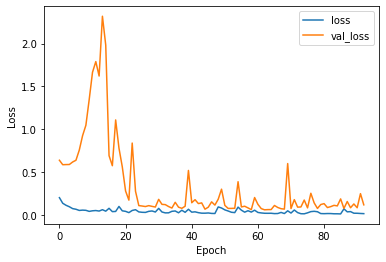

In [23]:
resnet18_hist_df.loc[:, ['loss', 'val_loss']].plot()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

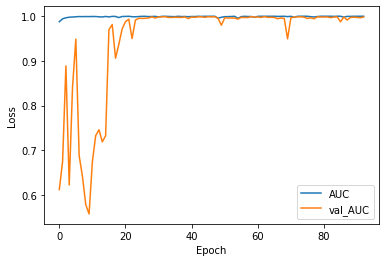

In [24]:
resnet18_hist_df.loc[:, ['AUC', 'val_AUC']].plot()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

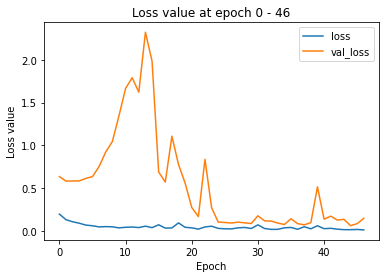

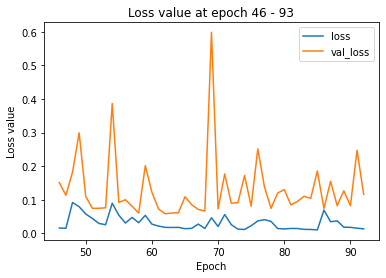

In [25]:
num_of_epochs = resnet18_hist_df.shape[0]
half_epoch = int(num_of_epochs / 2)

first_half_resnet18_hist = resnet18_hist_df.loc[:half_epoch]
first_title = f'Loss value at epoch 0 - { half_epoch }'

last_half_resnet18_hist = resnet18_hist_df.loc[half_epoch:len(resnet18_hist_df)]
last_title = f'Loss value at epoch { half_epoch } - { len(resnet18_hist_df) }'

hists = [first_half_resnet18_hist, last_half_resnet18_hist]
titles = [first_title, last_title]

for i in range(2):
    ax = hists[i][['loss', 'val_loss']].plot()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss value')
    ax.set_title(titles[i])
plt.show()

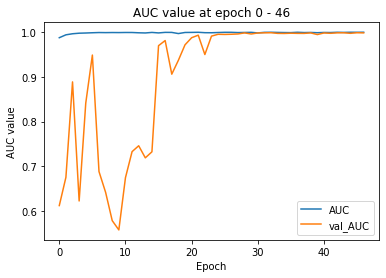

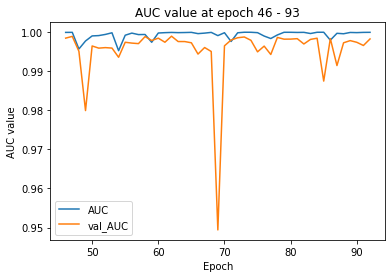

In [26]:
first_title = f'AUC value at epoch 0 - { half_epoch }'
last_title = f'AUC value at epoch { half_epoch } - { len(resnet18_hist_df) }'

titles = [first_title, last_title]

for i in range(2):
    ax = hists[i][['AUC', 'val_AUC']].plot()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('AUC value')
    ax.set_title(titles[i])
plt.show()

In [27]:
evaluate_resnet18 = ft_resnet18.evaluate(test_batches, verbose=1)

78/78 [==============================] - 10s 129ms/step - loss: 0.2233 - TP: 384.0000 - TN: 191.0000 - FP: 43.0000 - FN: 6.0000 - AUC: 0.9839


In [28]:
loss, tp, tn, fp, fn, auc = evaluate_resnet18[0], evaluate_resnet18[1], evaluate_resnet18[2], evaluate_resnet18[3], evaluate_resnet18[4], evaluate_resnet18[5]
print(f'Test loss: { loss }')
print(f'True positive: { tp }')
print(f'True negative: { tn }')
print(f'False positive: { fp }')
print(f'False negative: { fn }')
print('AUC: %.2f' % auc)

Test loss: 0.22333401441574097
True positive: 384.0
True negative: 191.0
False positive: 43.0
False negative: 6.0
AUC: 0.98


# 5. Plot PR curve and find optimal threshold

In [77]:
def find_optimal_threshold(precision, recall, threshold):
    f1_score = (2 * precision * recall) / (precision + recall)
    best_idx = np.argmax(f1_score)
    best_threshold = threshold[best_idx]
    return best_threshold, best_idx

**Find the best threshold**

In [78]:
y_true = test_batches.classes
y_predict = ft_resnet18.predict(test_batches)
precision, recall, threshold = precision_recall_curve(y_true, y_predict)
best_threshold, best_idx = find_optimal_threshold(precision, recall, threshold)
print('Best threshold: {}'.format(best_threshold))

Best threshold: 0.9406678676605225


**Plot ROC curve**

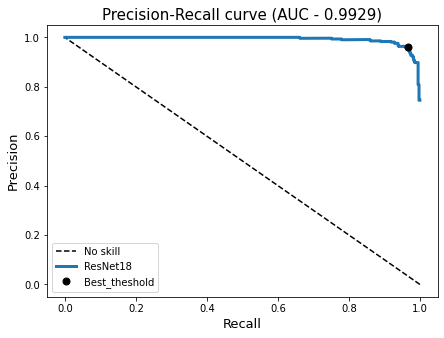

In [117]:
plt.figure(figsize=(7, 5))
auc_score = auc(recall, precision)
plt.plot([1, 0], [0, 1], linestyle='--', color='black', label='No skill')
plt.plot(recall, precision, linewidth=3, label='ResNet18')
plt.plot(recall[best_idx], precision[best_idx], 
         marker='o', color='black', 
         label='Best_theshold', linestyle='', markersize='7')
plt.xlabel('Recall', size=13)
plt.ylabel('Precision', size=13)
plt.title('Precision-Recall curve (AUC - {:.4f})'.format(auc_score), size=15)
plt.legend()
plt.show()

# 6. Predict and plot confusion matrix

In [92]:
y_predict = (y_predict >= best_threshold).astype('int')
y_predict = np.reshape(y_predict, -1)

In [102]:
cfs_matrix = confusion_matrix(y_true, y_predict)

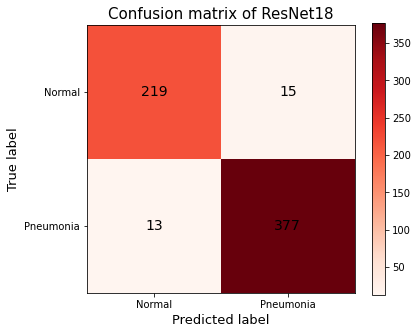

In [111]:
label = ['Normal', 'Pneumonia']

plt.figure(figsize=(6, 5))
plt.imshow(cfs_matrix, cmap=plt.cm.Reds)
plt.colorbar()
for i in range(len(label)):
    for j in range(len(label)):
        plt.text(j, i, cfs_matrix[i, j],
                 horizontalalignment='center', verticalalignment='center', size=14)
plt.xticks(np.arange(len(label)), label)
plt.yticks(np.arange(len(label)), label)
plt.xlabel('Predicted label', size=13)
plt.ylabel('True label', size=13)
plt.title('Confusion matrix of ResNet18', size=15)
plt.show()